# Imports

In [1]:
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os 
import json
from scipy.ndimage import distance_transform_edt

# Functions

In [2]:
# read the brightfield images and display them in one big figure (title is the filename)
def read_brightfield_images(PATH):
    brightfield_images = dict()
    # read all the images in the folder
    for filename in os.listdir(PATH):
        if filename.endswith(".tif"):
            img = imread(PATH+'\\'+filename)
            brightfield_images[filename] = img # store the image in a dictionary with the filename as key
    
    # display the images
    fig, ax = plt.subplots(1, len(brightfield_images), figsize=(20, 20))
    for i, (filename, img) in enumerate(brightfield_images.items()):
        # display the image without axis
        ax[i].imshow(img, cmap='gray')
        ax[i].axis('off')
        ax[i].set_title(filename, fontsize=5)
    return brightfield_images

In [3]:
def create_mask(width, height, tilt_angle, center_x, center_y):
    # function inputs:
    # brightfield: the brightfield image 
    # width: the width of the mask
    # height: the height of the mask
    # tilt_angle: the tilt angle of the mask in degrees
    # center_x: the x coordinate of the center of the mask
    # center_y: the y coordinate of the center of the mask

    # Convert tilt angle to radians
    tilt_angle_rad = np.radians(tilt_angle)

    # Create a meshgrid
    x = np.arange(2304)
    y = np.arange(4263)
    X, Y = np.meshgrid(x, y)

    # Translate coordinates to the center
    X_translated = X - center_x
    Y_translated = Y - center_y

    # Rotate coordinates
    X_rotated = X_translated * np.cos(tilt_angle_rad) + Y_translated * np.sin(tilt_angle_rad)
    Y_rotated = -X_translated * np.sin(tilt_angle_rad) + Y_translated * np.cos(tilt_angle_rad)

    # Create a mask for the rectangle
    rectangle_mask = (X_rotated > -width/2) & (X_rotated < width/2) & (Y_rotated > -height/2) & (Y_rotated < height/2)

    # Create masks for the half circles
    circle_mask1 = (X_rotated)**2 + (Y_rotated - height/2)**2 < (width/2)**2
    circle_mask2 = (X_rotated)**2 + (Y_rotated + height/2)**2 < (width/2)**2

    # Combine the masks
    mask = rectangle_mask | circle_mask1 | circle_mask2

    return mask

# Define file locations and read data

In [6]:
WORKING_DIR = 'd:\\David\\endoderm_migration\\raw_data\\2024_09_09_FoxA2_tdTom_c211to300_BmpAct_day2To3' # example: 'd:\\David\\endoderm_migration\\2024_09_09_FoxA2_tdTom_c211to300_BmpAct_day2To3'
BRIGHTFIELD_IMAGES_FOLDER = WORKING_DIR+'\\brightfield'
TRACKS_FOLDER = WORKING_DIR+'\\manual_tracks'

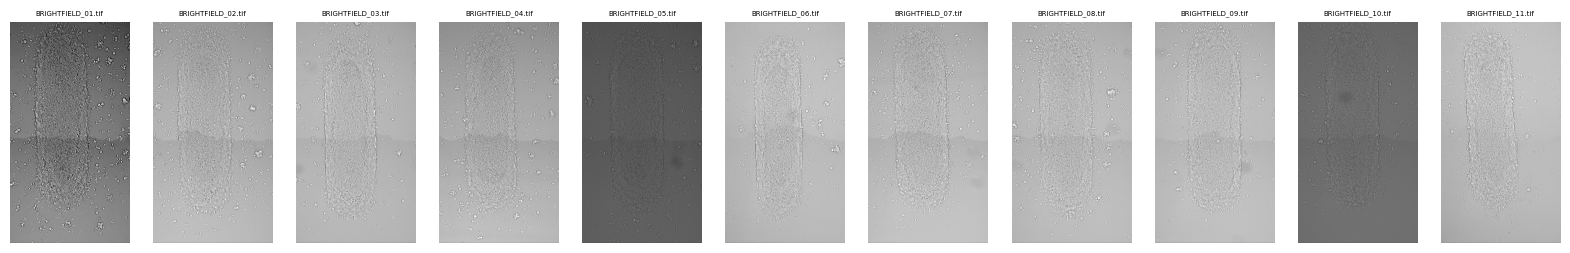

In [7]:
brightfield_images = read_brightfield_images(BRIGHTFIELD_IMAGES_FOLDER)

## pixel size

In [8]:
# pixel size in microns to convert the pixel coordinates to microns
pixel_size = 0.32 # microns

# Masks

In [9]:
masks_parameters_path = WORKING_DIR+'\\masks_parameters_2024-09-19_13-40-39-984581.json'
with open(masks_parameters_path) as f:
    masks_parameters_json = json.load(f)

## Distance maps

Using distance_transform_edt to calculate distance from the background (out of the mask) for each point:

1. Build a mask for each of the patterns seperatly based on the parametrs.
2. Calculate the distance_transform_edt
3. Assign to each coordinate in the dataframe it's distance from pattern edge value.

In [10]:
distance_maps = dict()
mask_centers = dict()

# from each mask parameters, create a mask and calculate the distance map
for brightfield_filename, mask_parameters in masks_parameters_json.items():
    image_id = brightfield_filename.split('_')[1].split('.')[0]
    print(image_id)

    # get center_x and center_y from the filename
    center_x = int(mask_parameters['center_x'])
    center_y = int(mask_parameters['center_y'])
    mask_centers[image_id] = (center_x, center_y)

    # create the mask
    mask = create_mask(**mask_parameters)

    # calculate distance from the edge of the mask (distance_transform_edt)
    distance_from_edge = distance_transform_edt(mask)
    
    # store the distance_from_edge map in a dictionary
    distance_maps[image_id] = distance_from_edge

01
02
03
04
05
06
07
08
09
10
11


# Tracks

In [11]:
# Initialize an empty DataFrame
raw_df = pd.DataFrame()

# Loop through each file in the specified folder
for filename in os.listdir(TRACKS_FOLDER):
    if filename.endswith(".csv"):
        # Read the CSV file into a temporary DataFrame
        temp_df = pd.read_csv(os.path.join(TRACKS_FOLDER, filename))
        
        # Add a new column with the filename to keep track of the source of each row
        temp_df['source_file'] = filename
        
        # Concatenate with the main DataFrame
        raw_df = pd.concat([raw_df, temp_df], ignore_index=True)

# change the column names to fit the rest of the code
raw_df = raw_df.rename(columns={'track': 'ID', 'frame': 't', 'source_file': 'file', 'X': 'x_pixels', 'Y': 'y_pixels'})

## Creating df

In [12]:
dt = 5 # time interval between frames in minutes

In [13]:
# create a DataFrame with all the coordinates and track IDs
tracks_df = raw_df[['file', 'ID', 't', 'x_pixels', 'y_pixels']].copy()

# calculate the normalized time for each track
tracks_df['t'] = tracks_df['t'] * dt # convert to actual time using dt
tracks_df['normalized_time'] = tracks_df.groupby(['ID','file'])['t'].transform(lambda x: x - x.min())
tracks_df['step'] = tracks_df['normalized_time']// dt

# add mask centers to the DataFrame
for filename in tracks_df['file'].unique():
    image_id = filename.split('_')[-1].split('.')[0]
    center_x, center_y = mask_centers[image_id]
    tracks_df.loc[tracks_df['file'] == filename, 'mask_center_x_pixels'] = center_x
    tracks_df.loc[tracks_df['file'] == filename, 'mask_center_y_pixels'] = center_y

tracks_df.reset_index(drop=True, inplace=True)

# combine file and ID to create a unique track ID
tracks_df['track_id'] = tracks_df['file'] + '_' + tracks_df['ID'].astype(str)

# for filename, ID in the DataFrame (each coordinate), assign the distance_from_edge from the edge of the mask
tracks_df['distance_from_edge_pixels'] = np.nan

for i, row in tracks_df.iterrows():
    image_id = row['file'].split('_')[1].split('.')[0]
    
    x = int(row['x_pixels'])
    y = int(row['y_pixels'])

    distance_from_edge = distance_maps[image_id][y, x]

    # insert the distance_from_edge in the DataFrame
    tracks_df.at[i, 'distance_from_edge_pixels'] = distance_from_edge

# convert units to microns
tracks_df['x_microns'] = tracks_df['x_pixels'] * pixel_size
tracks_df['y_microns'] = tracks_df['y_pixels'] * pixel_size
tracks_df['mask_center_x_microns'] = tracks_df['mask_center_x_pixels'] * pixel_size
tracks_df['mask_center_y_microns'] = tracks_df['mask_center_y_pixels'] * pixel_size
tracks_df['distance_from_edge_microns'] = tracks_df['distance_from_edge_pixels'] * pixel_size

# reorganize the DataFrame
tracks_df = tracks_df[['file', 'ID', 'track_id', 't', 'normalized_time', 'x_pixels', 'y_pixels', 'x_microns', 'y_microns', 'mask_center_x_pixels', 'mask_center_y_pixels', 'mask_center_x_microns', 'mask_center_y_microns', 'distance_from_edge_pixels', 'distance_from_edge_microns']]

tracks_df.head()

,file,ID,track_id,t,normalized_time,x_pixels,y_pixels,x_microns,y_microns,mask_center_x_pixels,mask_center_y_pixels,mask_center_x_microns,mask_center_y_microns,distance_from_edge_pixels,distance_from_edge_microns
0,2024_09_09_manual_tracks_01.csv,1,2024_09_09_manual_tracks_01.csv_1,5,0,1436,1074,459.52,343.68,1002.0,1868.0,320.64,597.76,231.000000,73.920000
1,2024_09_09_manual_tracks_01.csv,1,2024_09_09_manual_tracks_01.csv_1,10,5,1450,1078,464.00,344.96,1002.0,1868.0,320.64,597.76,217.000000,69.440000
2,2024_09_09_manual_tracks_01.csv,1,2024_09_09_manual_tracks_01.csv_1,15,10,1456,1078,465.92,344.96,1002.0,1868.0,320.64,597.76,211.000000,67.520000
3,2024_09_09_manual_tracks_01.csv,1,2024_09_09_manual_tracks_01.csv_1,20,15,1452,1062,464.64,339.84,1002.0,1868.0,320.64,597.76,214.841802,68.749377
4,2024_09_09_manual_tracks_01.csv,1,2024_09_09_manual_tracks_01.csv_1,25,20,1444,1068,462.08,341.76,1002.0,1868.0,320.64,597.76,223.000000,71.360000


In [14]:
# save the DataFrame to a csv file
save_to = r'D:\David\THESIS\tracks_dataframes'
tracks_df.to_csv(save_to+f'\\manual_tracks_df_{WORKING_DIR.split("\\")[-1]}.csv', index=False)

# Cell Counts

Text(0.5, 1.0, 'Cell Counts Per Timepoint')

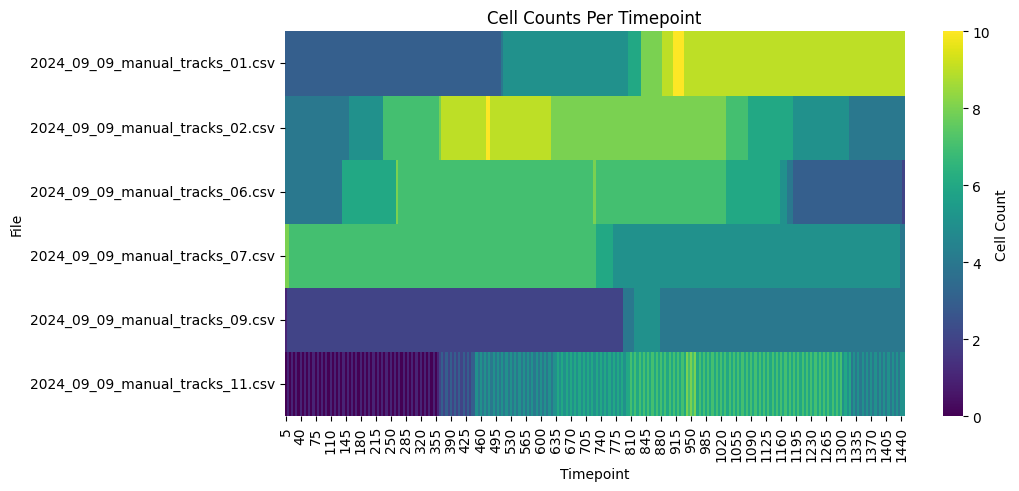

In [15]:
# create a df with cell counts per timepoint (rows: timepoints, columns: file, values: cell counts)
cell_counts = tracks_df.groupby(['file', 't']).size().unstack().fillna(0)

# plot the cell counts per timepoint
plt.figure(figsize=(10, 5))
sns.heatmap(cell_counts, cmap='viridis', cbar_kws={'label': 'Cell Count'})
plt.xlabel('Timepoint')
plt.ylabel('File')
plt.title('Cell Counts Per Timepoint')